In [24]:
!nvidia-smi -L

GPU 0: GeForce GTX 1650 (UUID: GPU-f982ddf8-eebf-afea-4d41-a6212401e1b3)


In [25]:
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")
#print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.6.0
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import os
import datetime as dt
import urllib.request, json
from pandas_datareader import data
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, SimpleRNN

np.random.seed(88)
tf.random.set_seed(88)

In [27]:
df = pd.read_csv('./btcthb_daily_5000n_bar.csv', parse_dates=['datetime'])
df = df.sort_values('datetime')
df.head()

,datetime,symbol,open,high,low,close,volume
0,2018-05-09,BITKUB:BTCTHB,293000.0,300000.0,287000.0,295950.0,2.132158
1,2018-05-10,BITKUB:BTCTHB,295950.0,299000.0,289351.0,299000.0,0.536473
2,2018-05-11,BITKUB:BTCTHB,294005.0,296000.0,270150.0,270150.0,1.889688
3,2018-05-12,BITKUB:BTCTHB,270151.0,288253.0,270150.0,280000.0,0.231786
4,2018-05-13,BITKUB:BTCTHB,280000.0,288252.0,277000.0,277200.0,1.817175


Text(0, 0.5, 'Close Price (THB)')

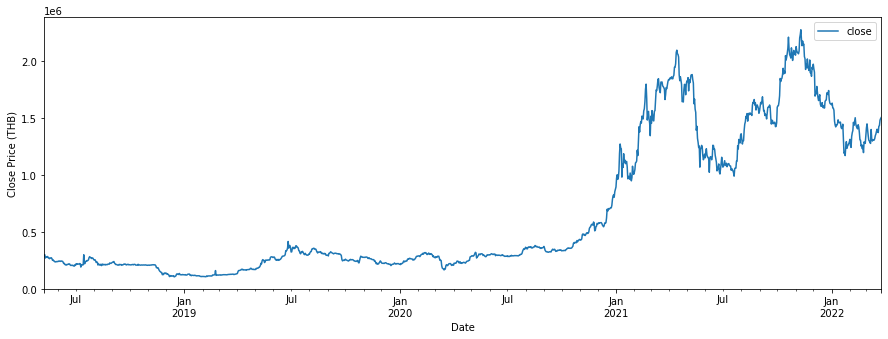

In [28]:
ax = df.plot(x='datetime', y='close', figsize=(15,5))
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (THB)")

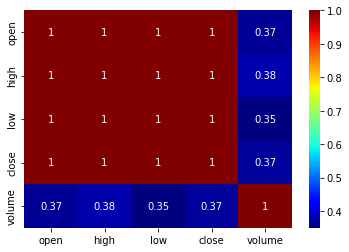

In [29]:
data = df.iloc[:, 2:].copy()

ax = sns.heatmap(data.corr(), cmap='jet', annot=True)

In [30]:
split_index = len(df) - 30
SEQ_LEN = 15

feature_dataset = df.iloc[:,2:]
label_dataset = df.iloc[:,5]

scaler = MinMaxScaler()
scaler_label = MinMaxScaler()

scaler.fit(feature_dataset.values[:split_index])
scaler_label.fit(label_dataset.values.reshape(-1,1)[:split_index])

feature_dataset = scaler.transform(feature_dataset.values)
label_dataset = scaler_label.transform(label_dataset.values.reshape(-1,1)).reshape(-1)

X_train_data = feature_dataset[0:split_index]
X_test_data = feature_dataset[split_index-SEQ_LEN:]

y_train_data = label_dataset[0:split_index]
y_test_data = label_dataset[split_index-SEQ_LEN:]

In [31]:
def to_sequence(X, y, seq_len):
    train_set, test_set = [], []
    
    for i in range(len(X) - seq_len):
        train_set.append(X[i:i+seq_len])
        test_set.append(y[i+seq_len])
        
    return np.array(train_set), np.array(test_set)

X_train, y_train = to_sequence(X_train_data, y_train_data, SEQ_LEN)
X_test, y_test = to_sequence(X_test_data, y_test_data, SEQ_LEN)

In [32]:
#Remmove Path
path_save = "./savemodel"
#os.rmdir(path_save)


#Remmove All Files in Path
import glob

#files = glob.glob('./savemodel/*')
files = glob.glob(path_save+'/*')
for f in files:
    os.remove(f)

In [33]:
# create a model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(16))
rnn_model.add(Dropout(0.1))
#rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(1))
rnn_model.add(Activation('linear'))


#rnn_model.compile(loss='mse', optimizer='adam', metrics=[])
rnn_model.compile(optimizer = 'adam', loss = 'mse')
checkpoint_filepath = "savemodel/RNN_bestmodel_epoch{epoch:03d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

#history = rnn_model.fit(X_train, y_train, epochs = 300, batch_size = 128, validation_split=0.2, callbacks=[model_checkpoint_callback])

In [34]:
#history = rnn_model.fit(X_train, y_train, epochs = 300, batch_size = 128, validation_split=0.2)

In [35]:
history = rnn_model.fit(X_train, y_train, epochs = 300, batch_size = 128, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/300
9/9 [==============================] - 2s 114ms/step - loss: 0.0123 - val_loss: 0.0063
Epoch 2/300
9/9 [==============================] - 1s 88ms/step - loss: 0.0085 - val_loss: 0.0050
Epoch 3/300
9/9 [==============================] - 1s 96ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 4/300
9/9 [==============================] - 1s 85ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 5/300
9/9 [==============================] - 1s 75ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 6/300
9/9 [==============================] - 1s 72ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 7/300
9/9 [==============================] - 1s 72ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 8/300
9/9 [==============================] - 1s 78ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 9/300
9/9 [==============================] - 0s 46ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 10/300
9/9 [==============================] - 0s 48ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 11/300
9/9 [

In [36]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 16)                352       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [41]:
best_model = max( [ f for f in os.listdir("./savemodel") if f.startswith('RNN_best') and f.endswith(".hdf5")] )
print(f"The best : {best_model}")

best_model_path="./savemodel/"+best_model
#best_model_path="./savemodel/"+"RNN_bestmodel_epoch299.hdf5"
print(f"Path best model: {best_model_path}")

best_rnn_model = tf.keras.models.load_model(best_model_path, compile=True)

score = best_rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"{best_rnn_model.metrics_names} = {score}")

The best : RNN_bestmodel_epoch295.hdf5
Path best model: ./savemodel/RNN_bestmodel_epoch295.hdf5
['loss'] = 0.00046770877088420093


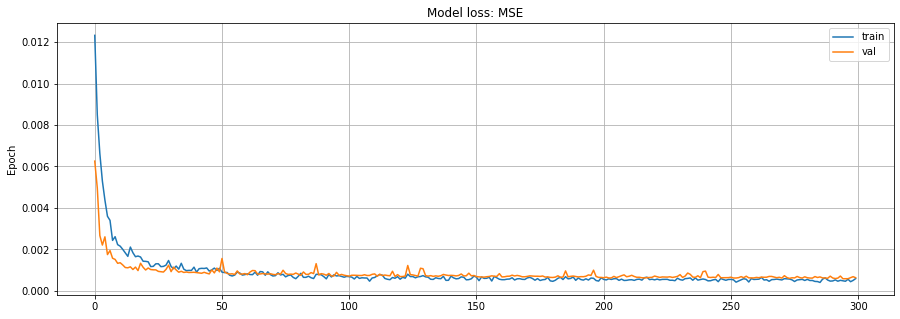

In [38]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss: MSE")
plt.ylabel('Loss')
plt.ylabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

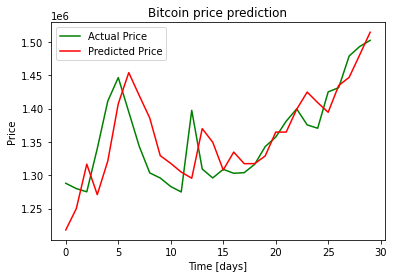

In [39]:
y_predict = best_rnn_model.predict(X_test)

y_test_inverse = scaler_label.inverse_transform(y_test.reshape(-1,1))
y_predict_inverse = scaler_label.inverse_transform(y_predict)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_predict_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [42]:
sse = 0
for i in range(len(y_predict_inverse)):
    sse += ((y_test_inverse[i][0] - y_predict_inverse[i][0]) ** 2)
print(sse)

mse = sse / len(y_predict_inverse)
print(mse)

65895068016.898285
2196502267.229943
